In [3]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
#from pmdarima import auto_arima
import seaborn as sns
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
warnings.filterwarnings("ignore")



In [4]:
#Let’s take a sneak peek at the data.
df =  pd.read_pickle('C:\\Users\\z0047cfr\\Project Work\\Factory Demand Model\\Input Data\\df_t.pkl')
df.index.freq = 'MS'
df['DATE']=df.index
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.loc[df.DATE >= '2015-12-01']
#df.head(5)

In [5]:
#Define the time-series evaluation function, as shown here:

def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true,y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true,y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true,y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

def get_rmse(y, y_hat):
    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

def get_mape(y, y_hat):
    perc_err = (100*(y - y_hat))/y
    return np.mean(abs(perc_err))

def get_mase(y, y_hat):

    abs_err = abs(y - y_hat)
    dsum=sum(abs(y[1:] - y_hat[1:]))
    t = len(y)
    denom = (1/(t - 1))* dsum
    return np.mean(abs_err/denom)

In [6]:
train_start =  0
train_end = len(df) - 12
train = df.iloc[train_start: train_end]

test_start = len(train)
test_end = len(train) + 9
test = df.iloc[len(train):len(train)+ 9] # 9 months of test post training


train_test = pd.concat([train, test], axis=0) # develop the model to retrain using train and test as development sample

val_start = len(train) + len(test) 
val_end =  len(train) +   len(test) + 3
val = df.iloc[len(train) + len(test): len(train) + len(test) + 3] # 3 months of validation post training+test 

#train_start , train_end , test_start, test_end, val_start, val_end 
#len(df), len(train), len(test), len(val), len(train_test)


# Grid Search for choosing orders of best SARIMA Model

Iteration and reslts

In [11]:
# Grid search SARIMAX
#  Grid Search
import itertools
#set parameter range
p = range(0,4)
q = range(0,4)
d = [1,2]
D = [0,1,2]
s = [0,6,9,12]
Final_1 = pd.DataFrame(columns= ['Order', 'Seasonal_Order', 'MSE','MAPE', 'AIC'])
dat = pd.DataFrame()
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, D, q, s))
# SARIMA model pipeline
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            order=[]
            seasonal_order=[]
            #Errors=[]
            AIC=[]
            mod = sm.tsa.statespace.SARIMAX(train.data,enforce_stationarity=True,
                                    order=param,seasonal_order=param_seasonal)
            results = mod.fit()
            
            predictions = results.predict(start=test_start, end=test_end-1,  dynamic=False, typ='levels').rename('forecast')
            test_pred = predictions.to_frame()
            test1 = pd.merge(test, test_pred, how = 'outer',left_index=True, right_index=True) 
                      
            
            from sklearn.metrics import mean_squared_error
            #print(test1[['data','forecast']].head(2))
                       
            MSE = metrics.mean_squared_error(test1.data, test1.forecast)
            def mean_absolute_percentage_error(y_true, y_pred):
               y_true, y_pred = np.array(y_true), np.array(y_pred)
               return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
            MAPE = mean_absolute_percentage_error(test1.data, test1.forecast)
            
            print('SARIMA{},{} - AIC:{}, Test MAPE:{}'.format(param, param_seasonal, results.aic.round(), MAPE.round()))
            cols = ['Order', 'Seasonal_Order', 'MSE','MAPE', 'AIC']
            dat = pd.DataFrame(columns = cols)
            dat = dat.append({'Order': param, 'Seasonal_Order':param_seasonal,'MSE': MSE,'MAPE':MAPE,'AIC':results.aic},ignore_index=True)

            Final_1= Final_1.append(dat)
            #print("Dataframe : " , dat, sep='\n')
        except:
            print("Code didnt run")
            continue


SARIMA(0, 1, 0),(0, 0, 0, 0) - AIC:308.0, Test MAPE:8.0
SARIMA(0, 1, 0),(0, 0, 0, 6) - AIC:308.0, Test MAPE:8.0
SARIMA(0, 1, 0),(0, 0, 0, 9) - AIC:308.0, Test MAPE:8.0
SARIMA(0, 1, 0),(0, 0, 0, 12) - AIC:308.0, Test MAPE:8.0
Code didnt run
SARIMA(0, 1, 0),(0, 0, 1, 6) - AIC:307.0, Test MAPE:13.0
SARIMA(0, 1, 0),(0, 0, 1, 9) - AIC:310.0, Test MAPE:11.0
SARIMA(0, 1, 0),(0, 0, 1, 12) - AIC:310.0, Test MAPE:8.0
Code didnt run
SARIMA(0, 1, 0),(0, 0, 2, 6) - AIC:308.0, Test MAPE:14.0
SARIMA(0, 1, 0),(0, 0, 2, 9) - AIC:308.0, Test MAPE:22.0
SARIMA(0, 1, 0),(0, 0, 2, 12) - AIC:311.0, Test MAPE:11.0
Code didnt run
SARIMA(0, 1, 0),(0, 0, 3, 6) - AIC:310.0, Test MAPE:14.0
SARIMA(0, 1, 0),(0, 0, 3, 9) - AIC:310.0, Test MAPE:21.0
SARIMA(0, 1, 0),(0, 0, 3, 12) - AIC:312.0, Test MAPE:13.0
Code didnt run
SARIMA(0, 1, 0),(0, 1, 0, 6) - AIC:291.0, Test MAPE:16.0
SARIMA(0, 1, 0),(0, 1, 0, 9) - AIC:261.0, Test MAPE:30.0
SARIMA(0, 1, 0),(0, 1, 0, 12) - AIC:237.0, Test MAPE:22.0
Code didnt run
SARIMA(0, 1, 

SARIMA(0, 1, 0),(3, 2, 0, 6) - AIC:260.0, Test MAPE:21.0
SARIMA(0, 1, 0),(3, 2, 0, 9) - AIC:209.0, Test MAPE:21.0
SARIMA(0, 1, 0),(3, 2, 0, 12) - AIC:162.0, Test MAPE:26.0
Code didnt run
SARIMA(0, 1, 0),(3, 2, 1, 6) - AIC:260.0, Test MAPE:9.0
SARIMA(0, 1, 0),(3, 2, 1, 9) - AIC:211.0, Test MAPE:28.0
SARIMA(0, 1, 0),(3, 2, 1, 12) - AIC:164.0, Test MAPE:26.0
Code didnt run
SARIMA(0, 1, 0),(3, 2, 2, 6) - AIC:261.0, Test MAPE:9.0
SARIMA(0, 1, 0),(3, 2, 2, 9) - AIC:213.0, Test MAPE:13.0
SARIMA(0, 1, 0),(3, 2, 2, 12) - AIC:166.0, Test MAPE:33.0
Code didnt run
SARIMA(0, 1, 0),(3, 2, 3, 6) - AIC:263.0, Test MAPE:9.0
SARIMA(0, 1, 0),(3, 2, 3, 9) - AIC:215.0, Test MAPE:18.0
SARIMA(0, 1, 0),(3, 2, 3, 12) - AIC:168.0, Test MAPE:32.0
SARIMA(0, 1, 1),(0, 0, 0, 0) - AIC:302.0, Test MAPE:7.0
SARIMA(0, 1, 1),(0, 0, 0, 6) - AIC:302.0, Test MAPE:7.0
SARIMA(0, 1, 1),(0, 0, 0, 9) - AIC:302.0, Test MAPE:7.0
SARIMA(0, 1, 1),(0, 0, 0, 12) - AIC:302.0, Test MAPE:7.0
Code didnt run
SARIMA(0, 1, 1),(0, 0, 1, 6) -

SARIMA(0, 1, 1),(3, 1, 0, 6) - AIC:276.0, Test MAPE:9.0
SARIMA(0, 1, 1),(3, 1, 0, 9) - AIC:251.0, Test MAPE:9.0
SARIMA(0, 1, 1),(3, 1, 0, 12) - AIC:237.0, Test MAPE:18.0
Code didnt run
SARIMA(0, 1, 1),(3, 1, 1, 6) - AIC:279.0, Test MAPE:9.0
SARIMA(0, 1, 1),(3, 1, 1, 9) - AIC:253.0, Test MAPE:9.0
SARIMA(0, 1, 1),(3, 1, 1, 12) - AIC:239.0, Test MAPE:18.0
Code didnt run
SARIMA(0, 1, 1),(3, 1, 2, 6) - AIC:279.0, Test MAPE:11.0
SARIMA(0, 1, 1),(3, 1, 2, 9) - AIC:255.0, Test MAPE:10.0
SARIMA(0, 1, 1),(3, 1, 2, 12) - AIC:241.0, Test MAPE:18.0
Code didnt run
SARIMA(0, 1, 1),(3, 1, 3, 6) - AIC:280.0, Test MAPE:12.0
SARIMA(0, 1, 1),(3, 1, 3, 9) - AIC:257.0, Test MAPE:11.0
SARIMA(0, 1, 1),(3, 1, 3, 12) - AIC:243.0, Test MAPE:18.0
Code didnt run
SARIMA(0, 1, 1),(3, 2, 0, 6) - AIC:255.0, Test MAPE:20.0
SARIMA(0, 1, 1),(3, 2, 0, 9) - AIC:205.0, Test MAPE:22.0
SARIMA(0, 1, 1),(3, 2, 0, 12) - AIC:161.0, Test MAPE:25.0
Code didnt run
SARIMA(0, 1, 1),(3, 2, 1, 6) - AIC:254.0, Test MAPE:8.0
SARIMA(0, 1, 

SARIMA(0, 1, 2),(3, 0, 0, 6) - AIC:308.0, Test MAPE:10.0
SARIMA(0, 1, 2),(3, 0, 0, 9) - AIC:308.0, Test MAPE:12.0
SARIMA(0, 1, 2),(3, 0, 0, 12) - AIC:309.0, Test MAPE:9.0
Code didnt run
SARIMA(0, 1, 2),(3, 0, 1, 6) - AIC:310.0, Test MAPE:10.0
SARIMA(0, 1, 2),(3, 0, 1, 9) - AIC:308.0, Test MAPE:12.0
SARIMA(0, 1, 2),(3, 0, 1, 12) - AIC:311.0, Test MAPE:9.0
Code didnt run
SARIMA(0, 1, 2),(3, 0, 2, 6) - AIC:311.0, Test MAPE:11.0
SARIMA(0, 1, 2),(3, 0, 2, 9) - AIC:310.0, Test MAPE:11.0
SARIMA(0, 1, 2),(3, 0, 2, 12) - AIC:313.0, Test MAPE:9.0
Code didnt run
SARIMA(0, 1, 2),(3, 0, 3, 6) - AIC:312.0, Test MAPE:12.0
SARIMA(0, 1, 2),(3, 0, 3, 9) - AIC:312.0, Test MAPE:11.0
SARIMA(0, 1, 2),(3, 0, 3, 12) - AIC:315.0, Test MAPE:9.0
Code didnt run
SARIMA(0, 1, 2),(3, 1, 0, 6) - AIC:278.0, Test MAPE:9.0
SARIMA(0, 1, 2),(3, 1, 0, 9) - AIC:253.0, Test MAPE:10.0
SARIMA(0, 1, 2),(3, 1, 0, 12) - AIC:239.0, Test MAPE:18.0
Code didnt run
SARIMA(0, 1, 2),(3, 1, 1, 6) - AIC:281.0, Test MAPE:9.0
SARIMA(0, 1, 2

SARIMA(0, 1, 3),(2, 2, 0, 6) - AIC:257.0, Test MAPE:14.0
SARIMA(0, 1, 3),(2, 2, 0, 9) - AIC:204.0, Test MAPE:22.0
SARIMA(0, 1, 3),(2, 2, 0, 12) - AIC:163.0, Test MAPE:32.0
Code didnt run
SARIMA(0, 1, 3),(2, 2, 1, 6) - AIC:256.0, Test MAPE:11.0
SARIMA(0, 1, 3),(2, 2, 1, 9) - AIC:206.0, Test MAPE:31.0
SARIMA(0, 1, 3),(2, 2, 1, 12) - AIC:165.0, Test MAPE:28.0
Code didnt run
SARIMA(0, 1, 3),(2, 2, 2, 6) - AIC:258.0, Test MAPE:12.0
SARIMA(0, 1, 3),(2, 2, 2, 9) - AIC:208.0, Test MAPE:34.0
SARIMA(0, 1, 3),(2, 2, 2, 12) - AIC:167.0, Test MAPE:24.0
Code didnt run
SARIMA(0, 1, 3),(2, 2, 3, 6) - AIC:259.0, Test MAPE:12.0
SARIMA(0, 1, 3),(2, 2, 3, 9) - AIC:210.0, Test MAPE:21.0
SARIMA(0, 1, 3),(2, 2, 3, 12) - AIC:169.0, Test MAPE:28.0
Code didnt run
SARIMA(0, 1, 3),(3, 0, 0, 6) - AIC:310.0, Test MAPE:10.0
SARIMA(0, 1, 3),(3, 0, 0, 9) - AIC:309.0, Test MAPE:15.0
SARIMA(0, 1, 3),(3, 0, 0, 12) - AIC:311.0, Test MAPE:10.0
Code didnt run
SARIMA(0, 1, 3),(3, 0, 1, 6) - AIC:312.0, Test MAPE:10.0
SARIMA(0

SARIMA(0, 2, 0),(2, 0, 3, 12) - AIC:318.0, Test MAPE:47.0
Code didnt run
SARIMA(0, 2, 0),(2, 1, 0, 6) - AIC:278.0, Test MAPE:71.0
SARIMA(0, 2, 0),(2, 1, 0, 9) - AIC:254.0, Test MAPE:35.0
SARIMA(0, 2, 0),(2, 1, 0, 12) - AIC:236.0, Test MAPE:43.0
Code didnt run
SARIMA(0, 2, 0),(2, 1, 1, 6) - AIC:280.0, Test MAPE:64.0
SARIMA(0, 2, 0),(2, 1, 1, 9) - AIC:256.0, Test MAPE:39.0
SARIMA(0, 2, 0),(2, 1, 1, 12) - AIC:238.0, Test MAPE:43.0
Code didnt run
SARIMA(0, 2, 0),(2, 1, 2, 6) - AIC:279.0, Test MAPE:43.0
SARIMA(0, 2, 0),(2, 1, 2, 9) - AIC:254.0, Test MAPE:13.0
SARIMA(0, 2, 0),(2, 1, 2, 12) - AIC:240.0, Test MAPE:43.0
Code didnt run
SARIMA(0, 2, 0),(2, 1, 3, 6) - AIC:281.0, Test MAPE:49.0
SARIMA(0, 2, 0),(2, 1, 3, 9) - AIC:256.0, Test MAPE:11.0
SARIMA(0, 2, 0),(2, 1, 3, 12) - AIC:242.0, Test MAPE:42.0
Code didnt run
SARIMA(0, 2, 0),(2, 2, 0, 6) - AIC:252.0, Test MAPE:152.0
SARIMA(0, 2, 0),(2, 2, 0, 9) - AIC:198.0, Test MAPE:31.0
SARIMA(0, 2, 0),(2, 2, 0, 12) - AIC:155.0, Test MAPE:28.0
Code d

SARIMA(0, 2, 1),(1, 2, 3, 12) - AIC:158.0, Test MAPE:45.0
Code didnt run
SARIMA(0, 2, 1),(2, 0, 0, 6) - AIC:307.0, Test MAPE:14.0
SARIMA(0, 2, 1),(2, 0, 0, 9) - AIC:309.0, Test MAPE:53.0
SARIMA(0, 2, 1),(2, 0, 0, 12) - AIC:310.0, Test MAPE:51.0
Code didnt run
SARIMA(0, 2, 1),(2, 0, 1, 6) - AIC:307.0, Test MAPE:14.0
SARIMA(0, 2, 1),(2, 0, 1, 9) - AIC:310.0, Test MAPE:50.0
SARIMA(0, 2, 1),(2, 0, 1, 12) - AIC:311.0, Test MAPE:44.0
Code didnt run
SARIMA(0, 2, 1),(2, 0, 2, 6) - AIC:308.0, Test MAPE:14.0
SARIMA(0, 2, 1),(2, 0, 2, 9) - AIC:310.0, Test MAPE:37.0
SARIMA(0, 2, 1),(2, 0, 2, 12) - AIC:312.0, Test MAPE:40.0
Code didnt run
SARIMA(0, 2, 1),(2, 0, 3, 6) - AIC:310.0, Test MAPE:15.0
SARIMA(0, 2, 1),(2, 0, 3, 9) - AIC:311.0, Test MAPE:23.0
SARIMA(0, 2, 1),(2, 0, 3, 12) - AIC:314.0, Test MAPE:39.0
Code didnt run
Code didnt run
SARIMA(0, 2, 1),(2, 1, 0, 9) - AIC:252.0, Test MAPE:35.0
SARIMA(0, 2, 1),(2, 1, 0, 12) - AIC:235.0, Test MAPE:25.0
Code didnt run
SARIMA(0, 2, 1),(2, 1, 1, 6) - AIC

SARIMA(0, 2, 2),(1, 1, 3, 12) - AIC:237.0, Test MAPE:26.0
Code didnt run
SARIMA(0, 2, 2),(1, 2, 0, 6) - AIC:255.0, Test MAPE:32.0
SARIMA(0, 2, 2),(1, 2, 0, 9) - AIC:203.0, Test MAPE:75.0
SARIMA(0, 2, 2),(1, 2, 0, 12) - AIC:152.0, Test MAPE:56.0
Code didnt run
SARIMA(0, 2, 2),(1, 2, 1, 6) - AIC:251.0, Test MAPE:33.0
SARIMA(0, 2, 2),(1, 2, 1, 9) - AIC:201.0, Test MAPE:66.0
SARIMA(0, 2, 2),(1, 2, 1, 12) - AIC:154.0, Test MAPE:56.0
Code didnt run
SARIMA(0, 2, 2),(1, 2, 2, 6) - AIC:251.0, Test MAPE:36.0
SARIMA(0, 2, 2),(1, 2, 2, 9) - AIC:203.0, Test MAPE:78.0
SARIMA(0, 2, 2),(1, 2, 2, 12) - AIC:156.0, Test MAPE:55.0
Code didnt run
SARIMA(0, 2, 2),(1, 2, 3, 6) - AIC:253.0, Test MAPE:30.0
SARIMA(0, 2, 2),(1, 2, 3, 9) - AIC:203.0, Test MAPE:71.0
SARIMA(0, 2, 2),(1, 2, 3, 12) - AIC:158.0, Test MAPE:56.0
Code didnt run
SARIMA(0, 2, 2),(2, 0, 0, 6) - AIC:303.0, Test MAPE:9.0
SARIMA(0, 2, 2),(2, 0, 0, 9) - AIC:304.0, Test MAPE:7.0
SARIMA(0, 2, 2),(2, 0, 0, 12) - AIC:305.0, Test MAPE:7.0
Code didnt

SARIMA(0, 2, 3),(1, 0, 3, 12) - AIC:309.0, Test MAPE:10.0
Code didnt run
SARIMA(0, 2, 3),(1, 1, 0, 6) - AIC:279.0, Test MAPE:11.0
SARIMA(0, 2, 3),(1, 1, 0, 9) - AIC:253.0, Test MAPE:14.0
SARIMA(0, 2, 3),(1, 1, 0, 12) - AIC:233.0, Test MAPE:19.0
Code didnt run
SARIMA(0, 2, 3),(1, 1, 1, 6) - AIC:277.0, Test MAPE:11.0
SARIMA(0, 2, 3),(1, 1, 1, 9) - AIC:254.0, Test MAPE:11.0
SARIMA(0, 2, 3),(1, 1, 1, 12) - AIC:235.0, Test MAPE:25.0
Code didnt run
SARIMA(0, 2, 3),(1, 1, 2, 6) - AIC:276.0, Test MAPE:17.0
SARIMA(0, 2, 3),(1, 1, 2, 9) - AIC:253.0, Test MAPE:13.0
SARIMA(0, 2, 3),(1, 1, 2, 12) - AIC:237.0, Test MAPE:26.0
Code didnt run
SARIMA(0, 2, 3),(1, 1, 3, 6) - AIC:278.0, Test MAPE:16.0
SARIMA(0, 2, 3),(1, 1, 3, 9) - AIC:254.0, Test MAPE:21.0
SARIMA(0, 2, 3),(1, 1, 3, 12) - AIC:239.0, Test MAPE:26.0
Code didnt run
SARIMA(0, 2, 3),(1, 2, 0, 6) - AIC:257.0, Test MAPE:21.0
SARIMA(0, 2, 3),(1, 2, 0, 9) - AIC:204.0, Test MAPE:66.0
SARIMA(0, 2, 3),(1, 2, 0, 12) - AIC:154.0, Test MAPE:61.0
Code di

SARIMA(1, 1, 0),(0, 2, 3, 9) - AIC:204.0, Test MAPE:13.0
SARIMA(1, 1, 0),(0, 2, 3, 12) - AIC:161.0, Test MAPE:27.0
Code didnt run
SARIMA(1, 1, 0),(1, 0, 0, 6) - AIC:303.0, Test MAPE:14.0
SARIMA(1, 1, 0),(1, 0, 0, 9) - AIC:306.0, Test MAPE:14.0
SARIMA(1, 1, 0),(1, 0, 0, 12) - AIC:306.0, Test MAPE:12.0
Code didnt run
SARIMA(1, 1, 0),(1, 0, 1, 6) - AIC:305.0, Test MAPE:14.0
SARIMA(1, 1, 0),(1, 0, 1, 9) - AIC:308.0, Test MAPE:10.0
SARIMA(1, 1, 0),(1, 0, 1, 12) - AIC:307.0, Test MAPE:14.0
Code didnt run
SARIMA(1, 1, 0),(1, 0, 2, 6) - AIC:307.0, Test MAPE:15.0
SARIMA(1, 1, 0),(1, 0, 2, 9) - AIC:307.0, Test MAPE:20.0
SARIMA(1, 1, 0),(1, 0, 2, 12) - AIC:309.0, Test MAPE:14.0
Code didnt run
SARIMA(1, 1, 0),(1, 0, 3, 6) - AIC:307.0, Test MAPE:14.0
SARIMA(1, 1, 0),(1, 0, 3, 9) - AIC:307.0, Test MAPE:15.0
SARIMA(1, 1, 0),(1, 0, 3, 12) - AIC:310.0, Test MAPE:14.0
Code didnt run
SARIMA(1, 1, 0),(1, 1, 0, 6) - AIC:279.0, Test MAPE:12.0
SARIMA(1, 1, 0),(1, 1, 0, 9) - AIC:252.0, Test MAPE:8.0
SARIMA(1,

SARIMA(1, 1, 1),(0, 1, 3, 6) - AIC:277.0, Test MAPE:12.0
SARIMA(1, 1, 1),(0, 1, 3, 9) - AIC:254.0, Test MAPE:7.0
SARIMA(1, 1, 1),(0, 1, 3, 12) - AIC:239.0, Test MAPE:18.0
Code didnt run
SARIMA(1, 1, 1),(0, 2, 0, 6) - AIC:266.0, Test MAPE:42.0
SARIMA(1, 1, 1),(0, 2, 0, 9) - AIC:209.0, Test MAPE:60.0
SARIMA(1, 1, 1),(0, 2, 0, 12) - AIC:160.0, Test MAPE:41.0
Code didnt run
SARIMA(1, 1, 1),(0, 2, 1, 6) - AIC:255.0, Test MAPE:13.0
SARIMA(1, 1, 1),(0, 2, 1, 9) - AIC:204.0, Test MAPE:29.0
SARIMA(1, 1, 1),(0, 2, 1, 12) - AIC:159.0, Test MAPE:30.0
Code didnt run
SARIMA(1, 1, 1),(0, 2, 2, 6) - AIC:252.0, Test MAPE:9.0
SARIMA(1, 1, 1),(0, 2, 2, 9) - AIC:204.0, Test MAPE:10.0
SARIMA(1, 1, 1),(0, 2, 2, 12) - AIC:161.0, Test MAPE:30.0
Code didnt run
SARIMA(1, 1, 1),(0, 2, 3, 6) - AIC:254.0, Test MAPE:11.0
SARIMA(1, 1, 1),(0, 2, 3, 9) - AIC:206.0, Test MAPE:11.0
SARIMA(1, 1, 1),(0, 2, 3, 12) - AIC:163.0, Test MAPE:31.0
Code didnt run
SARIMA(1, 1, 1),(1, 0, 0, 6) - AIC:304.0, Test MAPE:10.0
SARIMA(1, 

SARIMA(1, 1, 2),(0, 0, 3, 6) - AIC:309.0, Test MAPE:12.0
SARIMA(1, 1, 2),(0, 0, 3, 9) - AIC:309.0, Test MAPE:11.0
SARIMA(1, 1, 2),(0, 0, 3, 12) - AIC:311.0, Test MAPE:9.0
Code didnt run
SARIMA(1, 1, 2),(0, 1, 0, 6) - AIC:289.0, Test MAPE:11.0
SARIMA(1, 1, 2),(0, 1, 0, 9) - AIC:259.0, Test MAPE:25.0
SARIMA(1, 1, 2),(0, 1, 0, 12) - AIC:237.0, Test MAPE:22.0
Code didnt run
SARIMA(1, 1, 2),(0, 1, 1, 6) - AIC:279.0, Test MAPE:7.0
SARIMA(1, 1, 2),(0, 1, 1, 9) - AIC:256.0, Test MAPE:11.0
SARIMA(1, 1, 2),(0, 1, 1, 12) - AIC:238.0, Test MAPE:17.0
Code didnt run
SARIMA(1, 1, 2),(0, 1, 2, 6) - AIC:277.0, Test MAPE:15.0
SARIMA(1, 1, 2),(0, 1, 2, 9) - AIC:254.0, Test MAPE:7.0
SARIMA(1, 1, 2),(0, 1, 2, 12) - AIC:239.0, Test MAPE:17.0
Code didnt run
SARIMA(1, 1, 2),(0, 1, 3, 6) - AIC:279.0, Test MAPE:13.0
SARIMA(1, 1, 2),(0, 1, 3, 9) - AIC:256.0, Test MAPE:6.0
SARIMA(1, 1, 2),(0, 1, 3, 12) - AIC:241.0, Test MAPE:18.0
Code didnt run
SARIMA(1, 1, 2),(0, 2, 0, 6) - AIC:266.0, Test MAPE:46.0
SARIMA(1, 1,

SARIMA(1, 1, 2),(3, 2, 3, 6) - AIC:261.0, Test MAPE:11.0
SARIMA(1, 1, 2),(3, 2, 3, 9) - AIC:212.0, Test MAPE:9.0
SARIMA(1, 1, 2),(3, 2, 3, 12) - AIC:170.0, Test MAPE:49.0
SARIMA(1, 1, 3),(0, 0, 0, 0) - AIC:308.0, Test MAPE:8.0
SARIMA(1, 1, 3),(0, 0, 0, 6) - AIC:308.0, Test MAPE:8.0
SARIMA(1, 1, 3),(0, 0, 0, 9) - AIC:308.0, Test MAPE:8.0
SARIMA(1, 1, 3),(0, 0, 0, 12) - AIC:308.0, Test MAPE:8.0
Code didnt run
SARIMA(1, 1, 3),(0, 0, 1, 6) - AIC:308.0, Test MAPE:10.0
SARIMA(1, 1, 3),(0, 0, 1, 9) - AIC:310.0, Test MAPE:9.0
SARIMA(1, 1, 3),(0, 0, 1, 12) - AIC:310.0, Test MAPE:9.0
Code didnt run
SARIMA(1, 1, 3),(0, 0, 2, 6) - AIC:310.0, Test MAPE:12.0
SARIMA(1, 1, 3),(0, 0, 2, 9) - AIC:309.0, Test MAPE:22.0
SARIMA(1, 1, 3),(0, 0, 2, 12) - AIC:312.0, Test MAPE:8.0
Code didnt run
SARIMA(1, 1, 3),(0, 0, 3, 6) - AIC:311.0, Test MAPE:13.0
SARIMA(1, 1, 3),(0, 0, 3, 9) - AIC:311.0, Test MAPE:17.0
SARIMA(1, 1, 3),(0, 0, 3, 12) - AIC:312.0, Test MAPE:12.0
Code didnt run
SARIMA(1, 1, 3),(0, 1, 0, 6) - 

SARIMA(1, 1, 3),(3, 1, 3, 6) - AIC:286.0, Test MAPE:15.0
SARIMA(1, 1, 3),(3, 1, 3, 9) - AIC:262.0, Test MAPE:14.0
SARIMA(1, 1, 3),(3, 1, 3, 12) - AIC:249.0, Test MAPE:18.0
Code didnt run
SARIMA(1, 1, 3),(3, 2, 0, 6) - AIC:260.0, Test MAPE:37.0
SARIMA(1, 1, 3),(3, 2, 0, 9) - AIC:208.0, Test MAPE:13.0
SARIMA(1, 1, 3),(3, 2, 0, 12) - AIC:166.0, Test MAPE:52.0
Code didnt run
SARIMA(1, 1, 3),(3, 2, 1, 6) - AIC:259.0, Test MAPE:20.0
SARIMA(1, 1, 3),(3, 2, 1, 9) - AIC:210.0, Test MAPE:14.0
SARIMA(1, 1, 3),(3, 2, 1, 12) - AIC:168.0, Test MAPE:53.0
Code didnt run
SARIMA(1, 1, 3),(3, 2, 2, 6) - AIC:260.0, Test MAPE:22.0
SARIMA(1, 1, 3),(3, 2, 2, 9) - AIC:212.0, Test MAPE:14.0
SARIMA(1, 1, 3),(3, 2, 2, 12) - AIC:170.0, Test MAPE:52.0
Code didnt run
SARIMA(1, 1, 3),(3, 2, 3, 6) - AIC:262.0, Test MAPE:21.0
SARIMA(1, 1, 3),(3, 2, 3, 9) - AIC:214.0, Test MAPE:14.0
SARIMA(1, 1, 3),(3, 2, 3, 12) - AIC:172.0, Test MAPE:53.0
SARIMA(1, 2, 0),(0, 0, 0, 0) - AIC:309.0, Test MAPE:80.0
SARIMA(1, 2, 0),(0, 0, 

SARIMA(1, 2, 0),(3, 0, 2, 12) - AIC:317.0, Test MAPE:70.0
Code didnt run
SARIMA(1, 2, 0),(3, 0, 3, 6) - AIC:316.0, Test MAPE:39.0
SARIMA(1, 2, 0),(3, 0, 3, 9) - AIC:316.0, Test MAPE:49.0
SARIMA(1, 2, 0),(3, 0, 3, 12) - AIC:319.0, Test MAPE:70.0
Code didnt run
SARIMA(1, 2, 0),(3, 1, 0, 6) - AIC:280.0, Test MAPE:73.0
SARIMA(1, 2, 0),(3, 1, 0, 9) - AIC:251.0, Test MAPE:17.0
SARIMA(1, 2, 0),(3, 1, 0, 12) - AIC:239.0, Test MAPE:52.0
Code didnt run
SARIMA(1, 2, 0),(3, 1, 1, 6) - AIC:282.0, Test MAPE:73.0
SARIMA(1, 2, 0),(3, 1, 1, 9) - AIC:253.0, Test MAPE:18.0
SARIMA(1, 2, 0),(3, 1, 1, 12) - AIC:241.0, Test MAPE:51.0
Code didnt run
SARIMA(1, 2, 0),(3, 1, 2, 6) - AIC:282.0, Test MAPE:54.0
SARIMA(1, 2, 0),(3, 1, 2, 9) - AIC:255.0, Test MAPE:16.0
SARIMA(1, 2, 0),(3, 1, 2, 12) - AIC:243.0, Test MAPE:51.0
Code didnt run
SARIMA(1, 2, 0),(3, 1, 3, 6) - AIC:283.0, Test MAPE:52.0
SARIMA(1, 2, 0),(3, 1, 3, 9) - AIC:257.0, Test MAPE:15.0
SARIMA(1, 2, 0),(3, 1, 3, 12) - AIC:245.0, Test MAPE:51.0
Code di

SARIMA(1, 2, 1),(2, 2, 2, 9) - AIC:201.0, Test MAPE:63.0
SARIMA(1, 2, 1),(2, 2, 2, 12) - AIC:159.0, Test MAPE:51.0
Code didnt run
SARIMA(1, 2, 1),(2, 2, 3, 6) - AIC:256.0, Test MAPE:13.0
SARIMA(1, 2, 1),(2, 2, 3, 9) - AIC:203.0, Test MAPE:63.0
SARIMA(1, 2, 1),(2, 2, 3, 12) - AIC:161.0, Test MAPE:51.0
Code didnt run
SARIMA(1, 2, 1),(3, 0, 0, 6) - AIC:305.0, Test MAPE:13.0
SARIMA(1, 2, 1),(3, 0, 0, 9) - AIC:305.0, Test MAPE:15.0
SARIMA(1, 2, 1),(3, 0, 0, 12) - AIC:307.0, Test MAPE:12.0
Code didnt run
SARIMA(1, 2, 1),(3, 0, 1, 6) - AIC:307.0, Test MAPE:13.0
SARIMA(1, 2, 1),(3, 0, 1, 9) - AIC:305.0, Test MAPE:13.0
SARIMA(1, 2, 1),(3, 0, 1, 12) - AIC:309.0, Test MAPE:12.0
Code didnt run
SARIMA(1, 2, 1),(3, 0, 2, 6) - AIC:308.0, Test MAPE:14.0
SARIMA(1, 2, 1),(3, 0, 2, 9) - AIC:307.0, Test MAPE:13.0
SARIMA(1, 2, 1),(3, 0, 2, 12) - AIC:311.0, Test MAPE:12.0
Code didnt run
SARIMA(1, 2, 1),(3, 0, 3, 6) - AIC:309.0, Test MAPE:14.0
SARIMA(1, 2, 1),(3, 0, 3, 9) - AIC:309.0, Test MAPE:13.0
SARIMA(1

SARIMA(1, 2, 2),(2, 1, 2, 9) - AIC:253.0, Test MAPE:17.0
SARIMA(1, 2, 2),(2, 1, 2, 12) - AIC:239.0, Test MAPE:26.0
Code didnt run
SARIMA(1, 2, 2),(2, 1, 3, 6) - AIC:280.0, Test MAPE:16.0
SARIMA(1, 2, 2),(2, 1, 3, 9) - AIC:255.0, Test MAPE:14.0
SARIMA(1, 2, 2),(2, 1, 3, 12) - AIC:241.0, Test MAPE:26.0
Code didnt run
SARIMA(1, 2, 2),(2, 2, 0, 6) - AIC:253.0, Test MAPE:99.0
SARIMA(1, 2, 2),(2, 2, 0, 9) - AIC:199.0, Test MAPE:63.0
SARIMA(1, 2, 2),(2, 2, 0, 12) - AIC:156.0, Test MAPE:56.0
Code didnt run
SARIMA(1, 2, 2),(2, 2, 1, 6) - AIC:253.0, Test MAPE:45.0
SARIMA(1, 2, 2),(2, 2, 1, 9) - AIC:201.0, Test MAPE:63.0
SARIMA(1, 2, 2),(2, 2, 1, 12) - AIC:158.0, Test MAPE:60.0
Code didnt run
SARIMA(1, 2, 2),(2, 2, 2, 6) - AIC:256.0, Test MAPE:66.0
SARIMA(1, 2, 2),(2, 2, 2, 9) - AIC:203.0, Test MAPE:63.0
SARIMA(1, 2, 2),(2, 2, 2, 12) - AIC:160.0, Test MAPE:60.0
Code didnt run
SARIMA(1, 2, 2),(2, 2, 3, 6) - AIC:257.0, Test MAPE:33.0
SARIMA(1, 2, 2),(2, 2, 3, 9) - AIC:205.0, Test MAPE:63.0
SARIMA(1

SARIMA(1, 2, 3),(2, 0, 2, 9) - AIC:310.0, Test MAPE:9.0
SARIMA(1, 2, 3),(2, 0, 2, 12) - AIC:311.0, Test MAPE:9.0
Code didnt run
SARIMA(1, 2, 3),(2, 0, 3, 6) - AIC:310.0, Test MAPE:12.0
SARIMA(1, 2, 3),(2, 0, 3, 9) - AIC:310.0, Test MAPE:9.0
SARIMA(1, 2, 3),(2, 0, 3, 12) - AIC:313.0, Test MAPE:10.0
Code didnt run
SARIMA(1, 2, 3),(2, 1, 0, 6) - AIC:278.0, Test MAPE:11.0
SARIMA(1, 2, 3),(2, 1, 0, 9) - AIC:255.0, Test MAPE:10.0
SARIMA(1, 2, 3),(2, 1, 0, 12) - AIC:236.0, Test MAPE:27.0
Code didnt run
SARIMA(1, 2, 3),(2, 1, 1, 6) - AIC:280.0, Test MAPE:11.0
SARIMA(1, 2, 3),(2, 1, 1, 9) - AIC:254.0, Test MAPE:13.0
SARIMA(1, 2, 3),(2, 1, 1, 12) - AIC:238.0, Test MAPE:26.0
Code didnt run
SARIMA(1, 2, 3),(2, 1, 2, 6) - AIC:280.0, Test MAPE:18.0
SARIMA(1, 2, 3),(2, 1, 2, 9) - AIC:255.0, Test MAPE:16.0
SARIMA(1, 2, 3),(2, 1, 2, 12) - AIC:240.0, Test MAPE:26.0
Code didnt run
SARIMA(1, 2, 3),(2, 1, 3, 6) - AIC:282.0, Test MAPE:13.0
SARIMA(1, 2, 3),(2, 1, 3, 9) - AIC:258.0, Test MAPE:9.0
SARIMA(1, 2,

SARIMA(2, 1, 0),(1, 2, 2, 9) - AIC:207.0, Test MAPE:31.0
SARIMA(2, 1, 0),(1, 2, 2, 12) - AIC:163.0, Test MAPE:29.0
Code didnt run
SARIMA(2, 1, 0),(1, 2, 3, 6) - AIC:256.0, Test MAPE:10.0
SARIMA(2, 1, 0),(1, 2, 3, 9) - AIC:207.0, Test MAPE:17.0
SARIMA(2, 1, 0),(1, 2, 3, 12) - AIC:165.0, Test MAPE:28.0
Code didnt run
SARIMA(2, 1, 0),(2, 0, 0, 6) - AIC:307.0, Test MAPE:10.0
SARIMA(2, 1, 0),(2, 0, 0, 9) - AIC:308.0, Test MAPE:8.0
SARIMA(2, 1, 0),(2, 0, 0, 12) - AIC:309.0, Test MAPE:7.0
Code didnt run
SARIMA(2, 1, 0),(2, 0, 1, 6) - AIC:307.0, Test MAPE:11.0
SARIMA(2, 1, 0),(2, 0, 1, 9) - AIC:310.0, Test MAPE:9.0
SARIMA(2, 1, 0),(2, 0, 1, 12) - AIC:310.0, Test MAPE:8.0
Code didnt run
SARIMA(2, 1, 0),(2, 0, 2, 6) - AIC:309.0, Test MAPE:13.0
SARIMA(2, 1, 0),(2, 0, 2, 9) - AIC:310.0, Test MAPE:15.0
SARIMA(2, 1, 0),(2, 0, 2, 12) - AIC:312.0, Test MAPE:9.0
Code didnt run
SARIMA(2, 1, 0),(2, 0, 3, 6) - AIC:311.0, Test MAPE:12.0
SARIMA(2, 1, 0),(2, 0, 3, 9) - AIC:311.0, Test MAPE:12.0
SARIMA(2, 1, 

SARIMA(2, 1, 1),(1, 1, 2, 9) - AIC:256.0, Test MAPE:7.0
SARIMA(2, 1, 1),(1, 1, 2, 12) - AIC:241.0, Test MAPE:18.0
Code didnt run
SARIMA(2, 1, 1),(1, 1, 3, 6) - AIC:280.0, Test MAPE:13.0
SARIMA(2, 1, 1),(1, 1, 3, 9) - AIC:257.0, Test MAPE:8.0
SARIMA(2, 1, 1),(1, 1, 3, 12) - AIC:243.0, Test MAPE:18.0
Code didnt run
SARIMA(2, 1, 1),(1, 2, 0, 6) - AIC:260.0, Test MAPE:16.0
SARIMA(2, 1, 1),(1, 2, 0, 9) - AIC:209.0, Test MAPE:33.0
SARIMA(2, 1, 1),(1, 2, 0, 12) - AIC:160.0, Test MAPE:32.0
Code didnt run
SARIMA(2, 1, 1),(1, 2, 1, 6) - AIC:255.0, Test MAPE:9.0
SARIMA(2, 1, 1),(1, 2, 1, 9) - AIC:206.0, Test MAPE:17.0
SARIMA(2, 1, 1),(1, 2, 1, 12) - AIC:162.0, Test MAPE:36.0
Code didnt run
SARIMA(2, 1, 1),(1, 2, 2, 6) - AIC:256.0, Test MAPE:12.0
SARIMA(2, 1, 1),(1, 2, 2, 9) - AIC:209.0, Test MAPE:31.0
SARIMA(2, 1, 1),(1, 2, 2, 12) - AIC:164.0, Test MAPE:39.0
Code didnt run
SARIMA(2, 1, 1),(1, 2, 3, 6) - AIC:257.0, Test MAPE:10.0
SARIMA(2, 1, 1),(1, 2, 3, 9) - AIC:208.0, Test MAPE:17.0
SARIMA(2, 1

SARIMA(2, 1, 2),(1, 0, 2, 9) - AIC:312.0, Test MAPE:16.0
SARIMA(2, 1, 2),(1, 0, 2, 12) - AIC:313.0, Test MAPE:7.0
Code didnt run
SARIMA(2, 1, 2),(1, 0, 3, 6) - AIC:311.0, Test MAPE:12.0
SARIMA(2, 1, 2),(1, 0, 3, 9) - AIC:312.0, Test MAPE:12.0
SARIMA(2, 1, 2),(1, 0, 3, 12) - AIC:315.0, Test MAPE:10.0
Code didnt run
SARIMA(2, 1, 2),(1, 1, 0, 6) - AIC:283.0, Test MAPE:11.0
SARIMA(2, 1, 2),(1, 1, 0, 9) - AIC:258.0, Test MAPE:8.0
SARIMA(2, 1, 2),(1, 1, 0, 12) - AIC:239.0, Test MAPE:16.0
Code didnt run
SARIMA(2, 1, 2),(1, 1, 1, 6) - AIC:281.0, Test MAPE:10.0
SARIMA(2, 1, 2),(1, 1, 1, 9) - AIC:259.0, Test MAPE:6.0
SARIMA(2, 1, 2),(1, 1, 1, 12) - AIC:241.0, Test MAPE:18.0
Code didnt run
SARIMA(2, 1, 2),(1, 1, 2, 6) - AIC:281.0, Test MAPE:14.0
SARIMA(2, 1, 2),(1, 1, 2, 9) - AIC:258.0, Test MAPE:7.0
SARIMA(2, 1, 2),(1, 1, 2, 12) - AIC:243.0, Test MAPE:17.0
Code didnt run
SARIMA(2, 1, 2),(1, 1, 3, 6) - AIC:282.0, Test MAPE:14.0
SARIMA(2, 1, 2),(1, 1, 3, 9) - AIC:259.0, Test MAPE:7.0
SARIMA(2, 1, 

SARIMA(2, 1, 3),(0, 2, 2, 6) - AIC:258.0, Test MAPE:10.0
SARIMA(2, 1, 3),(0, 2, 2, 9) - AIC:207.0, Test MAPE:11.0
SARIMA(2, 1, 3),(0, 2, 2, 12) - AIC:165.0, Test MAPE:27.0
Code didnt run
SARIMA(2, 1, 3),(0, 2, 3, 6) - AIC:259.0, Test MAPE:13.0
SARIMA(2, 1, 3),(0, 2, 3, 9) - AIC:209.0, Test MAPE:11.0
SARIMA(2, 1, 3),(0, 2, 3, 12) - AIC:167.0, Test MAPE:26.0
Code didnt run
SARIMA(2, 1, 3),(1, 0, 0, 6) - AIC:306.0, Test MAPE:12.0
SARIMA(2, 1, 3),(1, 0, 0, 9) - AIC:307.0, Test MAPE:16.0
SARIMA(2, 1, 3),(1, 0, 0, 12) - AIC:307.0, Test MAPE:10.0
Code didnt run
SARIMA(2, 1, 3),(1, 0, 1, 6) - AIC:308.0, Test MAPE:12.0
SARIMA(2, 1, 3),(1, 0, 1, 9) - AIC:309.0, Test MAPE:16.0
SARIMA(2, 1, 3),(1, 0, 1, 12) - AIC:309.0, Test MAPE:13.0
Code didnt run
SARIMA(2, 1, 3),(1, 0, 2, 6) - AIC:310.0, Test MAPE:13.0
SARIMA(2, 1, 3),(1, 0, 2, 9) - AIC:309.0, Test MAPE:26.0
SARIMA(2, 1, 3),(1, 0, 2, 12) - AIC:309.0, Test MAPE:11.0
Code didnt run
SARIMA(2, 1, 3),(1, 0, 3, 6) - AIC:311.0, Test MAPE:12.0
SARIMA(2

SARIMA(2, 2, 0),(0, 1, 1, 12) - AIC:233.0, Test MAPE:23.0
Code didnt run
SARIMA(2, 2, 0),(0, 1, 2, 6) - AIC:273.0, Test MAPE:14.0
SARIMA(2, 2, 0),(0, 1, 2, 9) - AIC:250.0, Test MAPE:20.0
SARIMA(2, 2, 0),(0, 1, 2, 12) - AIC:234.0, Test MAPE:15.0
Code didnt run
SARIMA(2, 2, 0),(0, 1, 3, 6) - AIC:275.0, Test MAPE:14.0
SARIMA(2, 2, 0),(0, 1, 3, 9) - AIC:252.0, Test MAPE:19.0
SARIMA(2, 2, 0),(0, 1, 3, 12) - AIC:236.0, Test MAPE:15.0
Code didnt run
SARIMA(2, 2, 0),(0, 2, 0, 6) - AIC:260.0, Test MAPE:335.0
SARIMA(2, 2, 0),(0, 2, 0, 9) - AIC:206.0, Test MAPE:21.0
SARIMA(2, 2, 0),(0, 2, 0, 12) - AIC:154.0, Test MAPE:36.0
Code didnt run
SARIMA(2, 2, 0),(0, 2, 1, 6) - AIC:253.0, Test MAPE:139.0
SARIMA(2, 2, 0),(0, 2, 1, 9) - AIC:200.0, Test MAPE:17.0
SARIMA(2, 2, 0),(0, 2, 1, 12) - AIC:154.0, Test MAPE:24.0
Code didnt run
SARIMA(2, 2, 0),(0, 2, 2, 6) - AIC:250.0, Test MAPE:45.0
SARIMA(2, 2, 0),(0, 2, 2, 9) - AIC:201.0, Test MAPE:13.0
SARIMA(2, 2, 0),(0, 2, 2, 12) - AIC:156.0, Test MAPE:26.0
Code 

SARIMA(2, 2, 1),(0, 0, 1, 9) - AIC:308.0, Test MAPE:27.0
SARIMA(2, 2, 1),(0, 0, 1, 12) - AIC:308.0, Test MAPE:25.0
Code didnt run
SARIMA(2, 2, 1),(0, 0, 2, 6) - AIC:305.0, Test MAPE:11.0
SARIMA(2, 2, 1),(0, 0, 2, 9) - AIC:307.0, Test MAPE:19.0
SARIMA(2, 2, 1),(0, 0, 2, 12) - AIC:310.0, Test MAPE:28.0
Code didnt run
SARIMA(2, 2, 1),(0, 0, 3, 6) - AIC:307.0, Test MAPE:21.0
SARIMA(2, 2, 1),(0, 0, 3, 9) - AIC:309.0, Test MAPE:18.0
SARIMA(2, 2, 1),(0, 0, 3, 12) - AIC:310.0, Test MAPE:13.0
Code didnt run
SARIMA(2, 2, 1),(0, 1, 0, 6) - AIC:287.0, Test MAPE:107.0
SARIMA(2, 2, 1),(0, 1, 0, 9) - AIC:255.0, Test MAPE:20.0
SARIMA(2, 2, 1),(0, 1, 0, 12) - AIC:233.0, Test MAPE:26.0
Code didnt run
SARIMA(2, 2, 1),(0, 1, 1, 6) - AIC:278.0, Test MAPE:38.0
SARIMA(2, 2, 1),(0, 1, 1, 9) - AIC:255.0, Test MAPE:18.0
SARIMA(2, 2, 1),(0, 1, 1, 12) - AIC:235.0, Test MAPE:13.0
Code didnt run
SARIMA(2, 2, 1),(0, 1, 2, 6) - AIC:274.0, Test MAPE:17.0
SARIMA(2, 2, 1),(0, 1, 2, 9) - AIC:250.0, Test MAPE:9.0
SARIMA(2

SARIMA(2, 2, 1),(3, 2, 1, 9) - AIC:203.0, Test MAPE:63.0
SARIMA(2, 2, 1),(3, 2, 1, 12) - AIC:159.0, Test MAPE:78.0
Code didnt run
SARIMA(2, 2, 1),(3, 2, 2, 6) - AIC:257.0, Test MAPE:45.0
SARIMA(2, 2, 1),(3, 2, 2, 9) - AIC:205.0, Test MAPE:63.0
SARIMA(2, 2, 1),(3, 2, 2, 12) - AIC:161.0, Test MAPE:78.0
Code didnt run
SARIMA(2, 2, 1),(3, 2, 3, 6) - AIC:258.0, Test MAPE:13.0
SARIMA(2, 2, 1),(3, 2, 3, 9) - AIC:207.0, Test MAPE:64.0
SARIMA(2, 2, 1),(3, 2, 3, 12) - AIC:163.0, Test MAPE:78.0
SARIMA(2, 2, 2),(0, 0, 0, 0) - AIC:308.0, Test MAPE:45.0
SARIMA(2, 2, 2),(0, 0, 0, 6) - AIC:308.0, Test MAPE:45.0
SARIMA(2, 2, 2),(0, 0, 0, 9) - AIC:308.0, Test MAPE:45.0
SARIMA(2, 2, 2),(0, 0, 0, 12) - AIC:308.0, Test MAPE:45.0
Code didnt run
SARIMA(2, 2, 2),(0, 0, 1, 6) - AIC:309.0, Test MAPE:36.0
SARIMA(2, 2, 2),(0, 0, 1, 9) - AIC:310.0, Test MAPE:46.0
SARIMA(2, 2, 2),(0, 0, 1, 12) - AIC:310.0, Test MAPE:42.0
Code didnt run
SARIMA(2, 2, 2),(0, 0, 2, 6) - AIC:307.0, Test MAPE:10.0
SARIMA(2, 2, 2),(0, 0, 

SARIMA(2, 2, 2),(3, 1, 1, 6) - AIC:282.0, Test MAPE:12.0
SARIMA(2, 2, 2),(3, 1, 1, 9) - AIC:254.0, Test MAPE:11.0
SARIMA(2, 2, 2),(3, 1, 1, 12) - AIC:238.0, Test MAPE:13.0
Code didnt run
SARIMA(2, 2, 2),(3, 1, 2, 6) - AIC:282.0, Test MAPE:12.0
SARIMA(2, 2, 2),(3, 1, 2, 9) - AIC:256.0, Test MAPE:9.0
SARIMA(2, 2, 2),(3, 1, 2, 12) - AIC:241.0, Test MAPE:16.0
Code didnt run
SARIMA(2, 2, 2),(3, 1, 3, 6) - AIC:283.0, Test MAPE:16.0
SARIMA(2, 2, 2),(3, 1, 3, 9) - AIC:258.0, Test MAPE:13.0
SARIMA(2, 2, 2),(3, 1, 3, 12) - AIC:243.0, Test MAPE:16.0
Code didnt run
SARIMA(2, 2, 2),(3, 2, 0, 6) - AIC:257.0, Test MAPE:85.0
SARIMA(2, 2, 2),(3, 2, 0, 9) - AIC:202.0, Test MAPE:58.0
SARIMA(2, 2, 2),(3, 2, 0, 12) - AIC:157.0, Test MAPE:64.0
Code didnt run
SARIMA(2, 2, 2),(3, 2, 1, 6) - AIC:257.0, Test MAPE:35.0
SARIMA(2, 2, 2),(3, 2, 1, 9) - AIC:204.0, Test MAPE:58.0
SARIMA(2, 2, 2),(3, 2, 1, 12) - AIC:159.0, Test MAPE:64.0
Code didnt run
SARIMA(2, 2, 2),(3, 2, 2, 6) - AIC:259.0, Test MAPE:48.0
SARIMA(2,

SARIMA(2, 2, 3),(3, 0, 1, 6) - AIC:310.0, Test MAPE:11.0
SARIMA(2, 2, 3),(3, 0, 1, 9) - AIC:310.0, Test MAPE:11.0
SARIMA(2, 2, 3),(3, 0, 1, 12) - AIC:313.0, Test MAPE:11.0
Code didnt run
SARIMA(2, 2, 3),(3, 0, 2, 6) - AIC:312.0, Test MAPE:11.0
SARIMA(2, 2, 3),(3, 0, 2, 9) - AIC:312.0, Test MAPE:11.0
SARIMA(2, 2, 3),(3, 0, 2, 12) - AIC:315.0, Test MAPE:11.0
Code didnt run
SARIMA(2, 2, 3),(3, 0, 3, 6) - AIC:314.0, Test MAPE:11.0
SARIMA(2, 2, 3),(3, 0, 3, 9) - AIC:314.0, Test MAPE:12.0
SARIMA(2, 2, 3),(3, 0, 3, 12) - AIC:317.0, Test MAPE:11.0
Code didnt run
SARIMA(2, 2, 3),(3, 1, 0, 6) - AIC:280.0, Test MAPE:14.0
SARIMA(2, 2, 3),(3, 1, 0, 9) - AIC:254.0, Test MAPE:19.0
SARIMA(2, 2, 3),(3, 1, 0, 12) - AIC:239.0, Test MAPE:20.0
Code didnt run
SARIMA(2, 2, 3),(3, 1, 1, 6) - AIC:284.0, Test MAPE:13.0
SARIMA(2, 2, 3),(3, 1, 1, 9) - AIC:256.0, Test MAPE:21.0
SARIMA(2, 2, 3),(3, 1, 1, 12) - AIC:242.0, Test MAPE:42.0
Code didnt run
SARIMA(2, 2, 3),(3, 1, 2, 6) - AIC:285.0, Test MAPE:10.0
SARIMA(2

SARIMA(3, 1, 0),(2, 2, 1, 6) - AIC:255.0, Test MAPE:11.0
SARIMA(3, 1, 0),(2, 2, 1, 9) - AIC:206.0, Test MAPE:27.0
SARIMA(3, 1, 0),(2, 2, 1, 12) - AIC:165.0, Test MAPE:24.0
Code didnt run
SARIMA(3, 1, 0),(2, 2, 2, 6) - AIC:256.0, Test MAPE:13.0
SARIMA(3, 1, 0),(2, 2, 2, 9) - AIC:208.0, Test MAPE:30.0
SARIMA(3, 1, 0),(2, 2, 2, 12) - AIC:167.0, Test MAPE:24.0
Code didnt run
SARIMA(3, 1, 0),(2, 2, 3, 6) - AIC:258.0, Test MAPE:14.0
SARIMA(3, 1, 0),(2, 2, 3, 9) - AIC:210.0, Test MAPE:13.0
SARIMA(3, 1, 0),(2, 2, 3, 12) - AIC:169.0, Test MAPE:23.0
Code didnt run
SARIMA(3, 1, 0),(3, 0, 0, 6) - AIC:308.0, Test MAPE:11.0
SARIMA(3, 1, 0),(3, 0, 0, 9) - AIC:309.0, Test MAPE:13.0
SARIMA(3, 1, 0),(3, 0, 0, 12) - AIC:310.0, Test MAPE:10.0
Code didnt run
SARIMA(3, 1, 0),(3, 0, 1, 6) - AIC:310.0, Test MAPE:11.0
SARIMA(3, 1, 0),(3, 0, 1, 9) - AIC:309.0, Test MAPE:11.0
SARIMA(3, 1, 0),(3, 0, 1, 12) - AIC:312.0, Test MAPE:10.0
Code didnt run
SARIMA(3, 1, 0),(3, 0, 2, 6) - AIC:311.0, Test MAPE:12.0
SARIMA(3

SARIMA(3, 1, 1),(2, 1, 1, 6) - AIC:281.0, Test MAPE:11.0
SARIMA(3, 1, 1),(2, 1, 1, 9) - AIC:257.0, Test MAPE:10.0
SARIMA(3, 1, 1),(2, 1, 1, 12) - AIC:243.0, Test MAPE:17.0
Code didnt run
SARIMA(3, 1, 1),(2, 1, 2, 6) - AIC:282.0, Test MAPE:12.0
SARIMA(3, 1, 1),(2, 1, 2, 9) - AIC:258.0, Test MAPE:13.0
SARIMA(3, 1, 1),(2, 1, 2, 12) - AIC:245.0, Test MAPE:17.0
Code didnt run
SARIMA(3, 1, 1),(2, 1, 3, 6) - AIC:283.0, Test MAPE:12.0
SARIMA(3, 1, 1),(2, 1, 3, 9) - AIC:260.0, Test MAPE:8.0
SARIMA(3, 1, 1),(2, 1, 3, 12) - AIC:247.0, Test MAPE:17.0
Code didnt run
SARIMA(3, 1, 1),(2, 2, 0, 6) - AIC:259.0, Test MAPE:11.0
SARIMA(3, 1, 1),(2, 2, 0, 9) - AIC:206.0, Test MAPE:18.0
SARIMA(3, 1, 1),(2, 2, 0, 12) - AIC:165.0, Test MAPE:20.0
Code didnt run
SARIMA(3, 1, 1),(2, 2, 1, 6) - AIC:257.0, Test MAPE:12.0
SARIMA(3, 1, 1),(2, 2, 1, 9) - AIC:208.0, Test MAPE:25.0
SARIMA(3, 1, 1),(2, 2, 1, 12) - AIC:167.0, Test MAPE:28.0
Code didnt run
SARIMA(3, 1, 1),(2, 2, 2, 6) - AIC:258.0, Test MAPE:13.0
SARIMA(3,

SARIMA(3, 1, 2),(2, 0, 1, 6) - AIC:311.0, Test MAPE:14.0
SARIMA(3, 1, 2),(2, 0, 1, 9) - AIC:311.0, Test MAPE:23.0
SARIMA(3, 1, 2),(2, 0, 1, 12) - AIC:313.0, Test MAPE:11.0
Code didnt run
SARIMA(3, 1, 2),(2, 0, 2, 6) - AIC:312.0, Test MAPE:14.0
SARIMA(3, 1, 2),(2, 0, 2, 9) - AIC:310.0, Test MAPE:24.0
SARIMA(3, 1, 2),(2, 0, 2, 12) - AIC:315.0, Test MAPE:11.0
Code didnt run
SARIMA(3, 1, 2),(2, 0, 3, 6) - AIC:314.0, Test MAPE:12.0
SARIMA(3, 1, 2),(2, 0, 3, 9) - AIC:311.0, Test MAPE:15.0
SARIMA(3, 1, 2),(2, 0, 3, 12) - AIC:316.0, Test MAPE:12.0
Code didnt run
SARIMA(3, 1, 2),(2, 1, 0, 6) - AIC:281.0, Test MAPE:13.0
SARIMA(3, 1, 2),(2, 1, 0, 9) - AIC:259.0, Test MAPE:10.0
SARIMA(3, 1, 2),(2, 1, 0, 12) - AIC:239.0, Test MAPE:18.0
Code didnt run
SARIMA(3, 1, 2),(2, 1, 1, 6) - AIC:282.0, Test MAPE:13.0
SARIMA(3, 1, 2),(2, 1, 1, 9) - AIC:258.0, Test MAPE:12.0
SARIMA(3, 1, 2),(2, 1, 1, 12) - AIC:241.0, Test MAPE:16.0
Code didnt run
SARIMA(3, 1, 2),(2, 1, 2, 6) - AIC:283.0, Test MAPE:13.0
SARIMA(3

SARIMA(3, 1, 3),(1, 2, 1, 6) - AIC:261.0, Test MAPE:10.0
SARIMA(3, 1, 3),(1, 2, 1, 9) - AIC:211.0, Test MAPE:21.0
SARIMA(3, 1, 3),(1, 2, 1, 12) - AIC:168.0, Test MAPE:44.0
Code didnt run
SARIMA(3, 1, 3),(1, 2, 2, 6) - AIC:261.0, Test MAPE:22.0
SARIMA(3, 1, 3),(1, 2, 2, 9) - AIC:213.0, Test MAPE:30.0
SARIMA(3, 1, 3),(1, 2, 2, 12) - AIC:170.0, Test MAPE:47.0
Code didnt run
SARIMA(3, 1, 3),(1, 2, 3, 6) - AIC:263.0, Test MAPE:23.0
SARIMA(3, 1, 3),(1, 2, 3, 9) - AIC:213.0, Test MAPE:19.0
SARIMA(3, 1, 3),(1, 2, 3, 12) - AIC:172.0, Test MAPE:49.0
Code didnt run
SARIMA(3, 1, 3),(2, 0, 0, 6) - AIC:311.0, Test MAPE:13.0
SARIMA(3, 1, 3),(2, 0, 0, 9) - AIC:313.0, Test MAPE:10.0
SARIMA(3, 1, 3),(2, 0, 0, 12) - AIC:314.0, Test MAPE:10.0
Code didnt run
SARIMA(3, 1, 3),(2, 0, 1, 6) - AIC:313.0, Test MAPE:14.0
SARIMA(3, 1, 3),(2, 0, 1, 9) - AIC:315.0, Test MAPE:10.0
SARIMA(3, 1, 3),(2, 0, 1, 12) - AIC:311.0, Test MAPE:12.0
Code didnt run
SARIMA(3, 1, 3),(2, 0, 2, 6) - AIC:314.0, Test MAPE:14.0
SARIMA(3

SARIMA(3, 2, 0),(1, 1, 0, 12) - AIC:235.0, Test MAPE:12.0
Code didnt run
SARIMA(3, 2, 0),(1, 1, 1, 6) - AIC:278.0, Test MAPE:24.0
SARIMA(3, 2, 0),(1, 1, 1, 9) - AIC:255.0, Test MAPE:18.0
SARIMA(3, 2, 0),(1, 1, 1, 12) - AIC:236.0, Test MAPE:19.0
Code didnt run
SARIMA(3, 2, 0),(1, 1, 2, 6) - AIC:276.0, Test MAPE:12.0
SARIMA(3, 2, 0),(1, 1, 2, 9) - AIC:254.0, Test MAPE:7.0
SARIMA(3, 2, 0),(1, 1, 2, 12) - AIC:238.0, Test MAPE:25.0
Code didnt run
SARIMA(3, 2, 0),(1, 1, 3, 6) - AIC:277.0, Test MAPE:11.0
SARIMA(3, 2, 0),(1, 1, 3, 9) - AIC:255.0, Test MAPE:6.0
SARIMA(3, 2, 0),(1, 1, 3, 12) - AIC:240.0, Test MAPE:25.0
Code didnt run
SARIMA(3, 2, 0),(1, 2, 0, 6) - AIC:259.0, Test MAPE:142.0
SARIMA(3, 2, 0),(1, 2, 0, 9) - AIC:206.0, Test MAPE:30.0
SARIMA(3, 2, 0),(1, 2, 0, 12) - AIC:154.0, Test MAPE:72.0
Code didnt run
SARIMA(3, 2, 0),(1, 2, 1, 6) - AIC:254.0, Test MAPE:63.0
SARIMA(3, 2, 0),(1, 2, 1, 9) - AIC:203.0, Test MAPE:12.0
SARIMA(3, 2, 0),(1, 2, 1, 12) - AIC:156.0, Test MAPE:69.0
Code did

SARIMA(3, 2, 1),(1, 0, 0, 9) - AIC:310.0, Test MAPE:29.0
SARIMA(3, 2, 1),(1, 0, 0, 12) - AIC:306.0, Test MAPE:8.0
Code didnt run
SARIMA(3, 2, 1),(1, 0, 1, 6) - AIC:306.0, Test MAPE:10.0
SARIMA(3, 2, 1),(1, 0, 1, 9) - AIC:308.0, Test MAPE:8.0
SARIMA(3, 2, 1),(1, 0, 1, 12) - AIC:308.0, Test MAPE:8.0
Code didnt run
SARIMA(3, 2, 1),(1, 0, 2, 6) - AIC:307.0, Test MAPE:12.0
SARIMA(3, 2, 1),(1, 0, 2, 9) - AIC:311.0, Test MAPE:19.0
SARIMA(3, 2, 1),(1, 0, 2, 12) - AIC:309.0, Test MAPE:8.0
Code didnt run
SARIMA(3, 2, 1),(1, 0, 3, 6) - AIC:308.0, Test MAPE:12.0
SARIMA(3, 2, 1),(1, 0, 3, 9) - AIC:311.0, Test MAPE:10.0
SARIMA(3, 2, 1),(1, 0, 3, 12) - AIC:310.0, Test MAPE:10.0
Code didnt run
SARIMA(3, 2, 1),(1, 1, 0, 6) - AIC:280.0, Test MAPE:10.0
SARIMA(3, 2, 1),(1, 1, 0, 9) - AIC:255.0, Test MAPE:21.0
SARIMA(3, 2, 1),(1, 1, 0, 12) - AIC:235.0, Test MAPE:14.0
Code didnt run
SARIMA(3, 2, 1),(1, 1, 1, 6) - AIC:278.0, Test MAPE:12.0
SARIMA(3, 2, 1),(1, 1, 1, 9) - AIC:257.0, Test MAPE:20.0
SARIMA(3, 2,

SARIMA(3, 2, 2),(0, 2, 0, 6) - AIC:264.0, Test MAPE:260.0
SARIMA(3, 2, 2),(0, 2, 0, 9) - AIC:209.0, Test MAPE:76.0
SARIMA(3, 2, 2),(0, 2, 0, 12) - AIC:158.0, Test MAPE:36.0
Code didnt run
SARIMA(3, 2, 2),(0, 2, 1, 6) - AIC:257.0, Test MAPE:50.0
SARIMA(3, 2, 2),(0, 2, 1, 9) - AIC:204.0, Test MAPE:60.0
SARIMA(3, 2, 2),(0, 2, 1, 12) - AIC:158.0, Test MAPE:63.0
Code didnt run
SARIMA(3, 2, 2),(0, 2, 2, 6) - AIC:255.0, Test MAPE:33.0
SARIMA(3, 2, 2),(0, 2, 2, 9) - AIC:205.0, Test MAPE:48.0
SARIMA(3, 2, 2),(0, 2, 2, 12) - AIC:159.0, Test MAPE:78.0
Code didnt run
SARIMA(3, 2, 2),(0, 2, 3, 6) - AIC:256.0, Test MAPE:12.0
SARIMA(3, 2, 2),(0, 2, 3, 9) - AIC:206.0, Test MAPE:64.0
SARIMA(3, 2, 2),(0, 2, 3, 12) - AIC:161.0, Test MAPE:80.0
Code didnt run
SARIMA(3, 2, 2),(1, 0, 0, 6) - AIC:309.0, Test MAPE:20.0
SARIMA(3, 2, 2),(1, 0, 0, 9) - AIC:311.0, Test MAPE:38.0
SARIMA(3, 2, 2),(1, 0, 0, 12) - AIC:311.0, Test MAPE:37.0
Code didnt run
SARIMA(3, 2, 2),(1, 0, 1, 6) - AIC:311.0, Test MAPE:20.0
SARIMA(

SARIMA(3, 2, 3),(0, 0, 3, 12) - AIC:314.0, Test MAPE:14.0
Code didnt run
SARIMA(3, 2, 3),(0, 1, 0, 6) - AIC:286.0, Test MAPE:147.0
SARIMA(3, 2, 3),(0, 1, 0, 9) - AIC:259.0, Test MAPE:13.0
SARIMA(3, 2, 3),(0, 1, 0, 12) - AIC:236.0, Test MAPE:17.0
Code didnt run
SARIMA(3, 2, 3),(0, 1, 1, 6) - AIC:282.0, Test MAPE:10.0
SARIMA(3, 2, 3),(0, 1, 1, 9) - AIC:259.0, Test MAPE:9.0
SARIMA(3, 2, 3),(0, 1, 1, 12) - AIC:236.0, Test MAPE:15.0
Code didnt run
SARIMA(3, 2, 3),(0, 1, 2, 6) - AIC:278.0, Test MAPE:18.0
SARIMA(3, 2, 3),(0, 1, 2, 9) - AIC:256.0, Test MAPE:7.0
SARIMA(3, 2, 3),(0, 1, 2, 12) - AIC:240.0, Test MAPE:25.0
Code didnt run
SARIMA(3, 2, 3),(0, 1, 3, 6) - AIC:280.0, Test MAPE:23.0
SARIMA(3, 2, 3),(0, 1, 3, 9) - AIC:258.0, Test MAPE:7.0
SARIMA(3, 2, 3),(0, 1, 3, 12) - AIC:242.0, Test MAPE:21.0
Code didnt run
SARIMA(3, 2, 3),(0, 2, 0, 6) - AIC:258.0, Test MAPE:220.0
SARIMA(3, 2, 3),(0, 2, 0, 9) - AIC:209.0, Test MAPE:63.0
SARIMA(3, 2, 3),(0, 2, 0, 12) - AIC:159.0, Test MAPE:29.0
Code did

SARIMA(3, 2, 3),(3, 2, 3, 12) - AIC:168.0, Test MAPE:79.0


In [13]:
Final_1.to_excel('SARIMA_Gridshearch_8_Sept.xlsx', index = False, header=True)

# Final Chosen Orders based on the iteration with lowest AIC and MAPE combination

In [7]:
param = (0, 1, 1)
param_seasonal =  (0, 1, 3, 9)
print(" Chosen Orders (0, 1, 1)	(0, 1, 3, 9)") # Ok Diagnostics Test MAPE:  4.4  Train MAPE:  8.61
#(0, 1, 1)	(1, 1, 2, 9) ok diag. 9 m acf and pacf on resi sowing up est MAPE:  4.52 Train MAPE:  8.65
#(3, 2, 2)	(1, 1, 1, 9) ok diag Test MAPE:  4.94  Train MAPE:  9.91
#(0, 1, 2)	(0, 1, 2, 9) ok diag acf and pacf ok Test MAPE:  5.60 Train MAPE:  8.5
#(0, 1, 1)	(2, 1, 0, 9) ok diag Test MAPE:  5.5  Train MAPE:  8.51






 Chosen Orders (0, 1, 1)	(0, 1, 3, 9)


# Running the best SARIMA Model post grid search on train

In [8]:


# fit ARIMA monthly based on helper plots
model2 = sm.tsa.statespace.SARIMAX(train.data, enforce_stationarity= True,
                                    order=param,seasonal_order=param_seasonal).fit()
print(model2.summary())
# Obtain predicted values

predictions = model2.predict(start=test_start, end=test_end-1, dynamic=False, typ='levels').rename('forecast')
test_pred = predictions.to_frame()
test1 = pd.merge(test, test_pred, how = 'outer',left_index=True, right_index=True) 
print("MAPE: ",get_mape(test1.data, test1.forecast))    
print("MSE: ", mean_squared_error(test1.data, test1.forecast))
print("MAE: ", mean_absolute_error(test1.data, test1.forecast))

                                         SARIMAX Results                                         
Dep. Variable:                                      data   No. Observations:                   43
Model:             SARIMAX(0, 1, 1)x(0, 1, [1, 2, 3], 9)   Log Likelihood                -121.235
Date:                                   Thu, 17 Sep 2020   AIC                            252.470
Time:                                           12:29:55   BIC                            259.953
Sample:                                       12-01-2015   HQIC                           254.988
                                            - 06-01-2019                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4278      0.204      2.095      0.036    

In [9]:
#Ljung box test null hypothesis:  the hypothesis actually being tested is that the residuals from the ARIMA model have no autocorrelation
#    the P value of 0.99 makes us accept the null hypothesis
#https://en.wikipedia.org/wiki/Ljung%E2%80%93Box_test
    


In [10]:
# Retraining and FItting the Final Model on Validation set

In [25]:
# fit ARIMA monthly based on helper plots
model1_val = sm.tsa.statespace.SARIMAX(train_test.data,
                                    order=param,seasonal_order=param_seasonal).fit()
#print(model1_val.summary())
# Obtain predicted values

predictions_val = model1_val.predict(start=val_start, end=val_end+3, dynamic=False, typ='levels').rename('forecast')
val_pred = predictions_val.to_frame()
val1 = pd.merge(val, val_pred, how = 'outer',left_index=True, right_index=True) 
#print("MAPE: ", get_mape(val1.data, val1.forecast))    
#print("MSE: ",  mean_squared_error(val1.data, val1.forecast))
#print("MAE: ",  mean_absolute_error(val1.data, val1.forecast))

In [26]:
# Obtain predicted values on train data
start=1
end=len(train)+len(test)-1
predictions_train = model2.predict(start=train_start, end=train_end-1, dynamic=False, typ='levels').rename('forecast')
predictions_train
train_pred = predictions_train.to_frame()
train1 = pd.merge(train, train_pred, how = 'left',left_index=True, right_index=True)
train1 = train1.iloc[1:]
#train1[['data','forecast']].head(10)

# Test and Validation Actuals vs Forecasts

In [27]:
print("  ")
print("Test Dataset actuals and Forecasts")
test1[['data','forecast']].round(0)

  
Test Dataset actuals and Forecasts


,data,forecast
2019-07-01,103.0,98.0
2019-08-01,108.0,105.0
2019-09-01,112.0,108.0
2019-10-01,120.0,112.0
2019-11-01,116.0,107.0
2019-12-01,111.0,116.0
2020-01-01,115.0,116.0
2020-02-01,96.0,102.0
2020-03-01,99.0,98.0


In [28]:
print("  ")
print("Validation Dataset actuals and Forecasts")
val1[['data','forecast']].round(0)

  
Validation Dataset actuals and Forecasts


,data,forecast
2020-04-01,84.0,99.0
2020-05-01,97.0,110.0
2020-06-01,99.0,121.0
2020-07-01,NaN,128.0
2020-08-01,NaN,126.0
2020-09-01,NaN,141.0
2020-10-01,NaN,148.0


# Model Evaluation Metrics

In [15]:
# test metrics
print("Model Evaluation Metrics")   
print(" ")      

print("Test Model AIC : ", model2.aic.round(1))      
print("Test Model  : ", model2.bic.round(1))    
print(" ") 

print("Test MSE: ", mean_squared_error(test1.data, test1.forecast),        "             Val MSE: ", mean_squared_error(val1.data, val1.forecast), "             Train MSE: ", mean_squared_error(train1.data, train1.forecast))
print("Test MAE: ", mean_absolute_error(test1.data, test1.forecast),       "              Val MAE: ", mean_absolute_error(val1.data, val1.forecast), "            Train MAE: ", mean_absolute_error(train1.data, train1.forecast))
print("Test RMSE: ", get_rmse(test1.data, test1.forecast),                  "             Val RMSE: ", get_rmse(val1.data, val1.forecast), "           Train RMSE: ", get_rmse(train1.data, train1.forecast))
print("Test MAPE: ", get_mape(test1.data, test1.forecast),                  "             Val MAPE: ", get_mape(val1.data, val1.forecast), "           Train MAPE: ", get_mape(train1.data, train1.forecast))
print("Test MASE: ", get_mase(test1.data, test1.forecast),                  "            Val MASE: ", get_mase(val1.data, val1.forecast), "           Train MASE: ", get_mase(train1.data, train1.forecast))

Model Evaluation Metrics
 
Test Model AIC :  252.5
Test Model  :  260.0
 
Test MSE:  30.466854299838914              Val MSE:  293.2654345030584              Train MSE:  102.31437881962013
Test MAE:  4.881016521798464               Val MAE:  16.666663370622476             Train MAE:  7.518954875875208
Test RMSE:  5.519678822163379              Val RMSE:  17.124994438044595            Train RMSE:  10.115057034916815
Test MAPE:  4.447565508073365              Val MAPE:  17.802471908813203            Train MAPE:  8.615132271225667
Test MASE:  1.0044014524874112             Val MASE:  0.9405529516569772            Train MASE:  0.9761953480509701


# Graphical representation

Actual (in Blue) Vs forecast (in Orange)

           Train (Jan 16 - June 19)                  Test(July 19 - Mar 20)                Val ( Apr 20 - June 20)


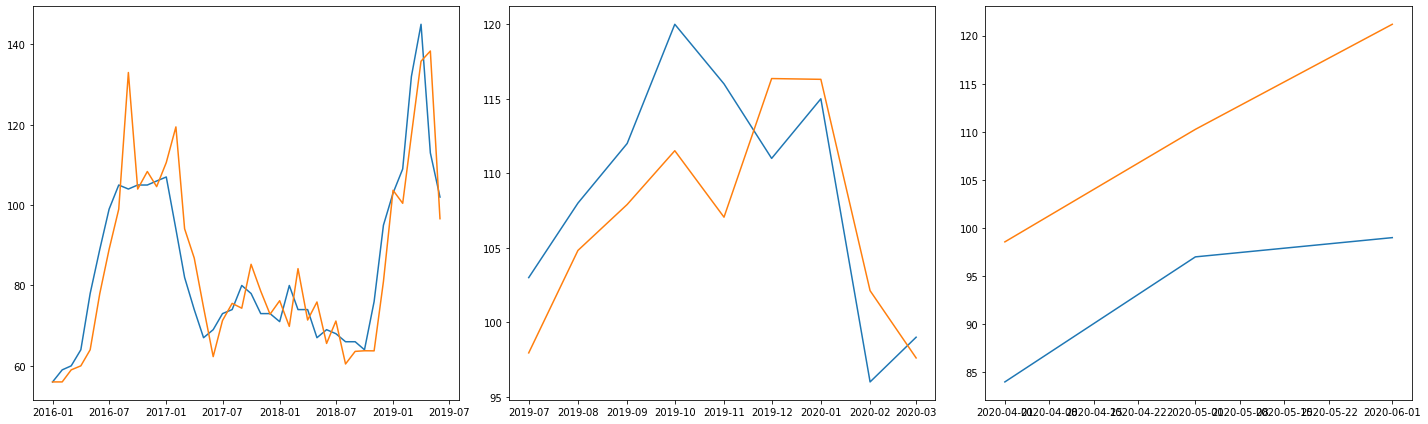

In [16]:
print("Actual (in Blue) Vs forecast (in Orange)")
print("")
print("           Train (Jan 16 - June 19)                  Test(July 19 - Mar 20)                Val ( Apr 20 - June 20)")
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%d')

x1 = np.linspace(0.0, 5.0)
x2 = np.linspace(0.0, 2.0)
y1 = np.cos(2 * np.pi * x1) * np.exp(-x1)
y2 = np.cos(2 * np.pi * x2)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
axes[0].plot(train1[['data','forecast']])
axes[1].plot(test1[['data','forecast']])
axes[2].plot(val1[['data','forecast']])
fig.tight_layout()

In [17]:
# define helper plot function for visualization
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

# Model Diagnostics on residuals

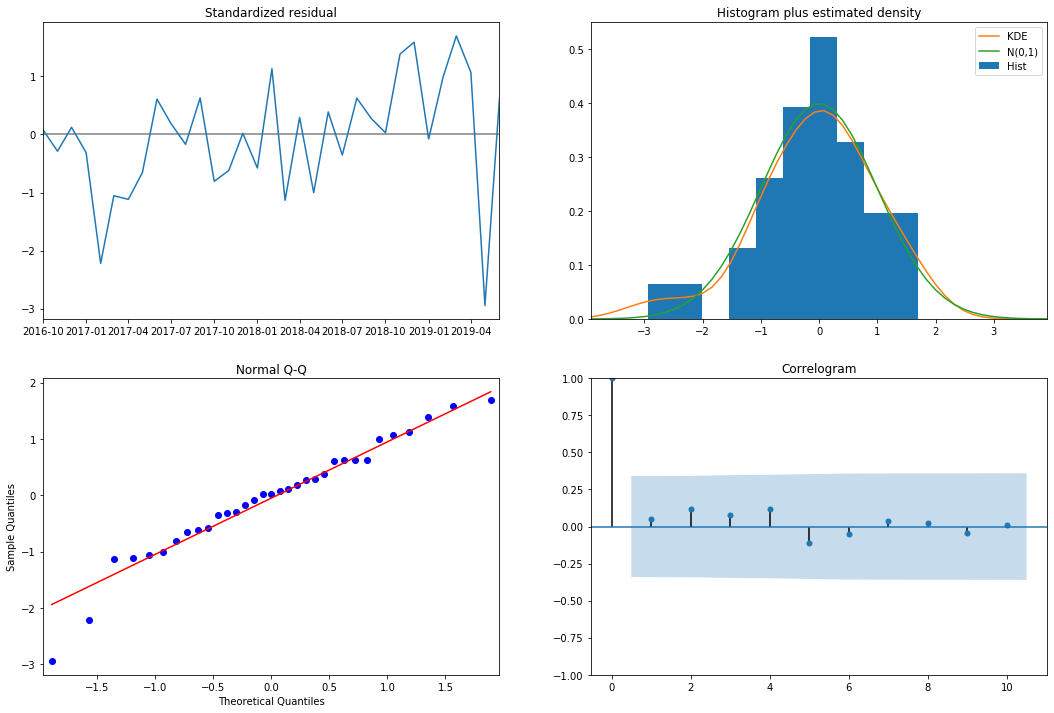

In [18]:
# plot residual diagnostics
model2.plot_diagnostics(figsize=(18, 12));

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the SARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). However we also we see the high variance towards the start and end of the graph suggesting possible further improvement

The residuals over time (top left plot) don’t display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

# ACF and PACF on residuals 

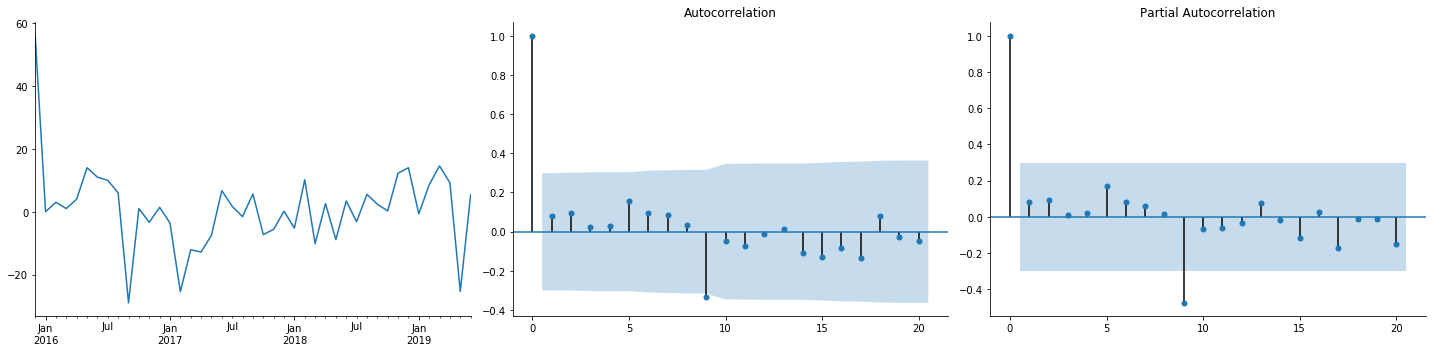

In [21]:
# plot resids
plt.figure(figsize=(20,5))
plots(model2.resid, lags=20);

In [2]:
import ipywidgets as widgets
from IPython.display import display, HTML

javascript_functions = {False: "hide()", True: "show()"}
button_descriptions  = {False: "Show code", True: "Hide code"}


def toggle_code(state):

    """
    Toggles the JavaScript show()/hide() function on the div.input element.
    """

    output_string = "<script>$(\"div.input\").{}</script>"
    output_args   = (javascript_functions[state],)
    output        = output_string.format(*output_args)

    display(HTML(output))


def button_action(value):

    """
    Calls the toggle_code function and updates the button description.
    """

    state = value.new

    toggle_code(state)

    value.owner.description = button_descriptions[state]


state = False
toggle_code(state)

button = widgets.ToggleButton(state, description = button_descriptions[state])
button.observe(button_action, "value")

display(button)

ToggleButton(value=False, description='Show code')